# In which neighborhood can I live in Gaziantep?
### Author: Servet Demir
Date: May, 14 2020

# 1. Introduction

## 1.1. Description & Disscusion of the Background

There are many factors that will determine which neighborhood you want to live in. for example; crowds,  parks, restaurants or cafes affect our choice. For some of us, we would prefer less crowded or near hospitals.
Gaziantep is one of the cities famous for its food culture. It is a city that is in the UNESCO cultural heritage at the moment (https://en.unesco.org/creative-cities/gaziantep). Promotional video https://www.youtube.com/watch?v=V5gvWa7PWIM
This project will be grouped only by considering the social facilities and population crowds of the central neighborhoods in Gaziantep. Basic features will be determined for each group. It will help the neighborhood preferences that people want to live in.

# 2. Data acquisition and cleaning

## 2.1 Data

In this project, we need five types of data;
1. Neighborhood list
2. The population in each neighborhood
3.  The venues in each neighborhood
4.  The rent rate (TL/m2) in each neighborhood 
5. The sales rate (TL/m2) in each neighborhood

From a web search,  I got four sources:
1. www.nufusu.com/ilce/sehitkamil_gaziantep-nufusu (Neighborhood list and population)
2. "https://www.nufusu.com/ilce/sahinbey_gaziantep-nufusu (Neighborhood list and population)
3. Foursquare API for getting venues place in neigborhoods
4. https://www.endeksa.com/tr/ (rent rate & sales rate)

## 2.2 Getting Data

In [26]:
# Importing Related Modules & library
# import numpy as np # library to handle data in a vectorized manner
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

import folium # map rendering library

print('Related Modeles & Libraries imported.')

Related Modeles & Libraries imported.


In [2]:
# Donloading Neigborhoods and polulation From web
# I select neighborhood in downtown
url1="https://www.nufusu.com/ilce/sehitkamil_gaziantep-nufusu"
skamil= pd.read_html(url1, header=0)
skamil=skamil[1]
skamil=skamil.iloc[0:20,:]
skamil.columns= ["year", "borough", "Neighborhood", "populations"]
url2="https://www.nufusu.com/ilce/sahinbey_gaziantep-nufusu"
sbey= pd.read_html(url2, header=0)
sbey=sbey[1]
sbey=sbey.iloc[0:20,:]
sbey.columns= ["year", "borough", "Neighborhood", "populations"]

In [3]:
# combine list and correct some neigborhood name
neighborhoods= pd.concat([skamil, sbey], ignore_index=True)
neighborhoods["Neighborhood"]=neighborhoods["Neighborhood"].map(lambda x: x.rstrip("Mah."))
neighborhoods["Neighborhood"]=neighborhoods["Neighborhood"].replace({"Eyüpsultan": "Eyüp Sultan", 
                                                                    "Fıstıklık": "Yukarıbeylerbeyi",
                                                                    "Zeytinli": "Zeytinli, Şehitkamil",
                                                                    "Beydilli": "Beydilli, Şahinbey",
                                                                    "Konak": "Konak, Şahinbey",
                                                                    "Karataş" : "Karataş, Şahinbey"}, regex=True)
neighborhoods.head()

,year,borough,Neighborhood,populations
0,2019,Şehitkamil,Seyrantepe,31.038
1,2019,Şehitkamil,Batıkent,29.010
2,2019,Şehitkamil,Güvenevler,28.945
3,2019,Şehitkamil,Atatürk,26.372
4,2019,Şehitkamil,Belkız,20.784


In [5]:
# Getting rent rate and Sales rate
data_rest_sales=pd.read_excel("data_rent_sales.xlsx")
data_rest_sales.head()

,Neighborhood,rent_rate,sales_rate
0,Seyrantepe,8,1576
1,Batıkent,12,2518
2,Güvenevler,12,2622
3,Atatürk,12,2507
4,Belkız,8,1809


In [6]:
# Addin to neighborhoods data base
neighborhoods["rent_rate"]=data_rest_sales["rent_rate"]
neighborhoods["sales_rate"]=data_rest_sales["sales_rate"]
neighborhoods.head()

,year,borough,Neighborhood,populations,rent_rate,sales_rate
0,2019,Şehitkamil,Seyrantepe,31.038,8,1576
1,2019,Şehitkamil,Batıkent,29.010,12,2518
2,2019,Şehitkamil,Güvenevler,28.945,12,2622
3,2019,Şehitkamil,Atatürk,26.372,12,2507
4,2019,Şehitkamil,Belkız,20.784,8,1809


### Add Latitude and Longititude

In [9]:
latitudes_list=[]
longitudes_list=[]
for i in list(neighborhoods["Neighborhood"]):
    address_geo = str(i+ ", Gaziantep")
    geolocator = Nominatim(user_agent="gaziantep_explorer")
    location = geolocator.geocode(address_geo)
    latitudes_list.append(location.latitude)
    longitudes_list.append(location.longitude)
    
neighborhoods["latitude"]=latitudes_list
neighborhoods["longitude"]=longitudes_list
neighborhoods.head()

,year,borough,Neighborhood,populations,rent_rate,sales_rate,latitude,longitude
0,2019,Şehitkamil,Seyrantepe,31.038,8,1576,37.074184,37.419598
1,2019,Şehitkamil,Batıkent,29.010,12,2518,37.074242,37.332576
2,2019,Şehitkamil,Güvenevler,28.945,12,2622,37.091903,37.333514
3,2019,Şehitkamil,Atatürk,26.372,12,2507,37.061176,37.379309
4,2019,Şehitkamil,Belkız,20.784,8,1809,37.097496,37.420558


### Getting Avenue from Foursquare API

In [1]:
#@hidden_cell
CLIENT_ID = 'AVWXDD1SMJ1FTUNHKGP.......' # your Foursquare ID
CLIENT_SECRET = 'RGIDVNE5Y1LGZM12.......' # your Foursquare Secret
VERSION = '20200510' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AVWXDD1SMJ1FTUNHKGP.......
CLIENT_SECRET:RGIDVNE5Y1LGZM12.......


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
all_venues = getNearbyVenues(names=neighborhoods["Neighborhood"],latitudes=neighborhoods["latitude"], longitudes=neighborhoods["longitude"])
all_venues.head()

Seyrantepe 
Batıkent 
Güvenevler 
Atatürk 
Belkız 
Mevlana 
Selimiye 
8 Şubat 
Zeytinli, Şehitkamil 
Şirinevler 
Burak 
Karacaoğlan 
Beykent 
Göllüce 
Eyüp Sultan 
Değirmiçem 
Mücahitler 
Onat Kutlar 
Yukarıbeylerbeyi 
Merveşehir 
Karataş, Şahinbey 
Yeditepe 
Güneykent 
Şahintepe 
Güneş 
Akkent 
Bülbülzade 
Barak 
Vatan 
İstiklal 
Mavikent 
Konak, Şahinbey 
Onur 
Beydilli, Şahinbey 
Yeşilevler 
Dumlupınar 
60.Yıl 
Ertuğrulgazi 
75.Yıl 
Binevler 


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Seyrantepe,37.074184,37.419598,Seyrantepe Park,37.072523,37.418011,Park
1,Seyrantepe,37.074184,37.419598,Seyir Tepesi,37.072686,37.413857,National Park
2,Seyrantepe,37.074184,37.419598,Ayintap Aluminyum,37.081086,37.422042,Department Store
3,Seyrantepe,37.074184,37.419598,Seyyah Kebap,37.076675,37.429455,Steakhouse
4,Seyrantepe,37.074184,37.419598,Seyrantepe Spor Tesisleri,37.075631,37.413700,Gym / Fitness Center


# 3. Methodology

In Gaziantep, there 9 boroughs but only two of them (Şahinbey & Şehitkamil) downtown. So that, in this project, I select to study these boroughs. Also, there are villages and I dismiss that from the neighborhood list. Then I  got the populations, rent rate, and sales rate for each neighborhood. Then I got latitudes and longitude of all neighborhoods in order to get the venues. Then I will cluster analysis for neighborhoods. For model features, I will use venue categories, populations, rent rates, and sales rates.

## Exploring Data

In [137]:
# The Maps of Neigborhoods in Gaziantep
latitude=37.0686307
longitude=37.3674178
map_gaziantep = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['latitude'],neighborhoods['longitude'], neighborhoods['borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gaziantep)  
    
map_gaziantep

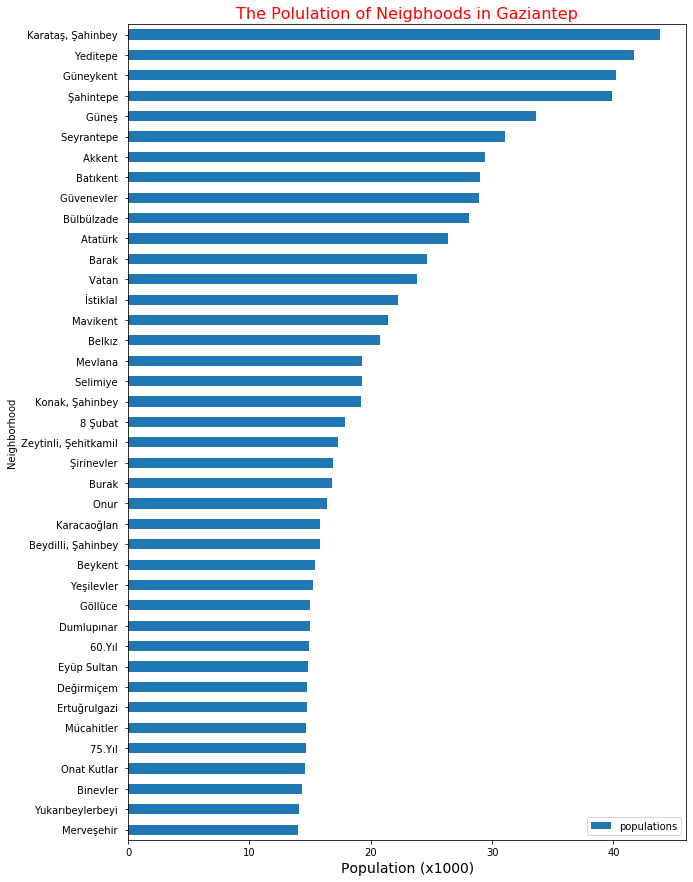

In [82]:
# Population in Neigborhoods

neighborhoods.sort_values(by='populations',ascending=True).plot.barh(x="Neighborhood", y= "populations", 
                        figsize=(10, 15))
plt.xlabel("Population (x1000)", fontsize=14)
plt.title("The Polulation of Neigbhoods in Gaziantep", fontsize=16, c="red");

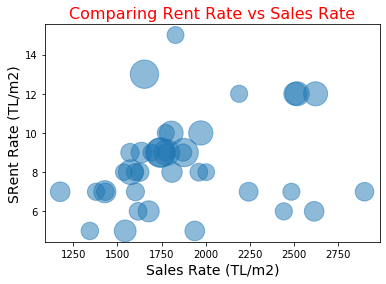

In [121]:
# Compare Sales Rate and Rent Rate
plt.scatter(x=neighborhoods["sales_rate"], y= neighborhoods["rent_rate"],
            alpha = 0.5 ,s=neighborhoods["populations"]*20)

plt.title ("Comparing Rent Rate vs Sales Rate", fontsize=16, c="red")
plt.xlabel("Sales Rate (TL/m2)", fontsize=14)
plt.ylabel("SRent Rate (TL/m2)", fontsize=14);

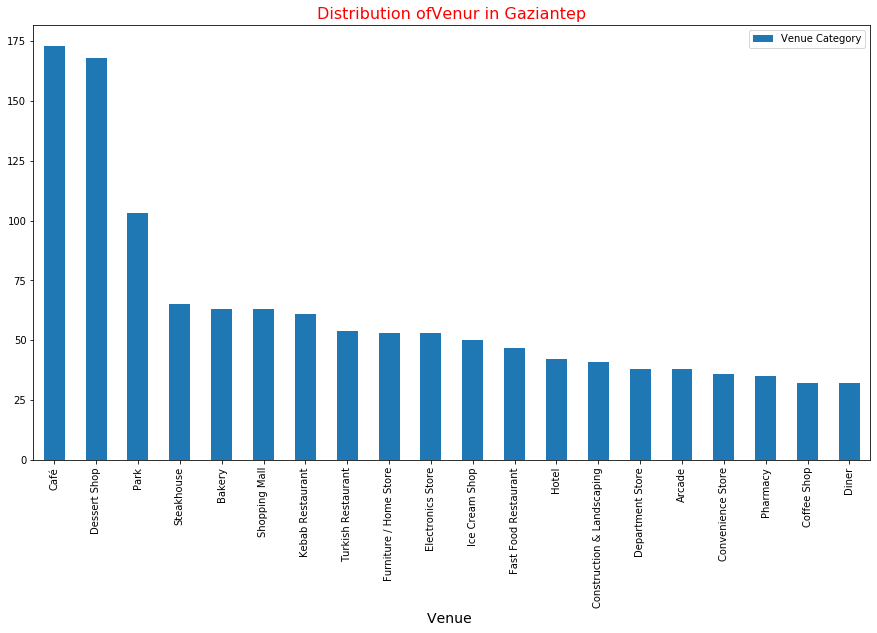

In [135]:
# Top 20 Venues Categories in Gaziantep
top_20_venues=all_venues["Venue Category"].value_counts().to_frame().reset_index()
top_20_venues=top_20_venues.iloc[:20,:]
top_20_venues.plot.bar(x="index", y= "Venue Category", 
                        figsize=(15, 8))
plt.xlabel("Venue ", fontsize=14)
plt.title("Distribution of Venue in Gaziantep", fontsize=16, c="red");

In [ ]:
# In Gaziantep, there is special Dessert (Baklava), also it is servised in Cafe 

# 4. Analyzing Data

In [24]:
# one hot encoding
gaziantep_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gaziantep_onehot['Neighborhood'] = all_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [gaziantep_onehot.columns[-1] ]+ gaziantep_onehot.columns[:-1].tolist()
gaziantep_onehot = gaziantep_onehot[fixed_columns]

gaziantep_onehot.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Stadium,Bath House,Beer Bar,Beer Garden,Big Box Store,Bookstore,Border Crossing,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Carpet Store,Castle,Check Cashing Service,Cheese Shop,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Fabric Shop,Farm,Fast Food Restaurant,Fish Market,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Frame Store,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Gozleme Place,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Kuruyemişçi,Lake,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Meyhane,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Molecular Gastronomy Restaurant,Mosque,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Night Market,Nightclub,Nudist Beach,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outlet Store,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,RV Park,Racecourse,Real Estate Office,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Sake Bar,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,Souvenir Shop,Spa,Sporting Goods Shop,Sports Club,Stadium,Stationery Store,Steakhouse,Summer Camp,Supermarket,Tailor Shop,Tantuni Restaurant,Taxi Stand,Tea Room,Tech Startup,Theater,Theme Restaurant,Toll Booth,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Travel Agency,Tree,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Watch Shop,Water Park,Whisky Bar,Wine Shop,Wings Joint,Women's Store
0,Seyrantepe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [27]:
#  let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. 
# Adding population, rent rate, sales rate
gaziantep_grouped = gaziantep_onehot.groupby('Neighborhood').mean().reset_index()
# first I will scale the feature in order to similiar effect size
gaziantep_grouped["populations"]=preprocessing.MinMaxScaler(feature_range=(0,0.1)).fit_transform(np.array(neighborhoods["populations"]).reshape(-1,1))
gaziantep_grouped["rent_rate"]=preprocessing.MinMaxScaler(feature_range=(0,0.1)).fit_transform(np.array(neighborhoods["rent_rate"]).reshape(-1,1))
gaziantep_grouped["sales_rate"]=preprocessing.MinMaxScaler(feature_range=(0,0.05)).fit_transform(np.array(neighborhoods["sales_rate"]).reshape(-1,1))
gaziantep_grouped.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Stadium,Bath House,Beer Bar,Beer Garden,Big Box Store,Bookstore,Border Crossing,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Carpet Store,Castle,Check Cashing Service,Cheese Shop,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Fabric Shop,Farm,Fast Food Restaurant,Fish Market,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Frame Store,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Gozleme Place,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Kuruyemişçi,Lake,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Meyhane,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Molecular Gastronomy Restaurant,Mosque,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Night Market,Nightclub,Nudist Beach,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outlet Store,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,RV Park,Racecourse,Real Estate Office,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Sake Bar,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,Souvenir Shop,Spa,Sporting Goods Shop,Sports Club,Stadium,Stationery Store,Steakhouse,Summer Camp,Supermarket,Tailor Shop,Tantuni Restaurant,Taxi Stand,Tea Room,Tech Startup,Theater,Theme Restaurant,Toll Booth,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Travel Agency,Tree,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Watch Shop,Water Park,Whisky Bar,Wine Shop,Wings Joint,Women's Store,populations,rent_rate,sales_rate
0,60.Yıl,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.023256,0.011628,0.00,0.011628,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.023256,0.034884,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.011628,0.0,0.0,0.000000,0.0,0.011628,0.000000,0.0,0.000000,0.0,0.023256,0.023256,0.0,0.0,0.00,0.0,0.00,0.0,0.011628,0.000000,0.0,0.000000,0.0,0.011628,0.011628,0.000000,0.000000,0.011628,0.023256,0.0,0.

## Cluster Neighborhoods

In [30]:
# Prepare data for kmeans
gaziantep_grouped_clustering =gaziantep_grouped.drop('Neighborhood', 1)

In [31]:
# Optimze k value
ssd=[]
K= range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(gaziantep_grouped_clustering)
    ssd.append(kmeans.inertia_)

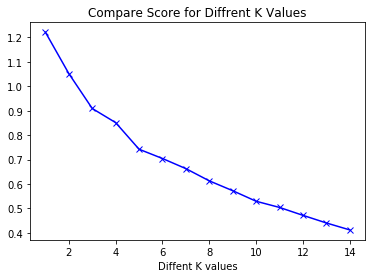

In [32]:
import matplotlib.pyplot as plt
plt.plot(K,ssd, "bx-")
plt.title( "Compare Score for Diffrent K Values")
plt.xlabel("Diffent K values")
plt.show()

In [50]:
# set number of clusters
kclusters = 5


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gaziantep_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 3, 1, 3, 1, 3, 3, 0], dtype=int32)

# 5. Results

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = gaziantep_grouped['Neighborhood']

for ind in np.arange(gaziantep_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(gaziantep_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,60.Yıl,Dessert Shop,Electronics Store,Park,populations,Steakhouse,Fast Food Restaurant,Bakery,Furniture / Home Store,rent_rate,Restaurant
1,75.Yıl,Dessert Shop,rent_rate,Electronics Store,Construction & Landscaping,Bakery,populations,Bagel Shop,Furniture / Home Store,Pool,Convenience Store
2,8 Şubat,rent_rate,Shopping Mall,populations,Park,Steakhouse,Dessert Shop,Café,Big Box Store,sales_rate,Tailor Shop
3,Akkent,Pool,Steakhouse,rent_rate,Recreation Center,Athletics & Sports,Scenic Lookout,Big Box Store,Basketball Stadium,Soccer Field,Market
4,Atatürk,Dessert Shop,Hotel,Kebab Restaurant,Historic Site,Café,Turkish Restaurant,Restaurant,rent_rate,Art Gallery,populations


In [53]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

gaziantep_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
gaziantep_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

gaziantep_merged.head() # check the last columns!

,year,borough,Neighborhood,populations,rent_rate,sales_rate,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2019,Şehitkamil,Seyrantepe,31.038,8,1576,37.074184,37.419598,3,Furniture / Home Store,Department Store,Big Box Store,Steakhouse,Park,Fast Food Restaurant,Bus Stop,Food Court,Food & Drink Shop,Garden
1,2019,Şehitkamil,Batıkent,29.010,12,2518,37.074242,37.332576,1,Café,Furniture / Home Store,Ice Cream Shop,Dessert Shop,sales_rate,Turkish Restaurant,Coffee Shop,Arcade,Music Venue,Gym / Fitness Center
2,2019,Şehitkamil,Güvenevler,28.945,12,2622,37.091903,37.333514,1,Café,Park,populations,Dessert Shop,rent_rate,Gym / Fitness Center,Gym,Grocery Store,Shopping Mall,Bridal Shop
3,2019,Şehitkamil,Atatürk,26.372,12,2507,37.061176,37.379309,1,Dessert Shop,Hotel,Kebab Restaurant,Historic Site,Café,Turkish Restaurant,Restaurant,rent_rate,Art Gallery,populations
4,2019,Şehitkamil,Belkız,20.784,8,1809,37.097496,37.420558,3,Park,Steakhouse,Restaurant,Electronics Store,Department Store,Dessert Shop,Bakery,Café,Arts & Entertainment,Moving Target


## Cluster Features

In [138]:
# create map
latitude=37.0686307
longitude=37.3674178
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(gaziantep_merged['latitude'], gaziantep_merged['longitude'], gaziantep_merged['Neighborhood'], gaziantep_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [55]:
gaziantep_merged.loc[gaziantep_merged['Cluster Labels'] == 0, gaziantep_merged.columns[[2] + list(range(5, gaziantep_merged.shape[1]))]]

,Neighborhood,sales_rate,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Beykent,1432,37.124922,37.406337,0,Mountain,Construction & Landscaping,Italian Restaurant,Buffet,Movie Theater,Park,Perfume Shop,Dessert Shop,Racecourse,Convenience Store
18,Yukarıbeylerbeyi,2003,37.125480,37.388549,0,Moving Target,Ice Cream Shop,Dessert Shop,Soccer Stadium,Business Service,Shopping Mall,Construction & Landscaping,Stadium,rent_rate,Food & Drink Shop


### Cluster 2

In [56]:
gaziantep_merged.loc[gaziantep_merged['Cluster Labels'] == 1, gaziantep_merged.columns[[2] + list(range(5, gaziantep_merged.shape[1]))]]

,Neighborhood,sales_rate,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Batıkent,2518,37.074242,37.332576,1,Café,Furniture / Home Store,Ice Cream Shop,Dessert Shop,sales_rate,Turkish Restaurant,Coffee Shop,Arcade,Music Venue,Gym / Fitness Center
2,Güvenevler,2622,37.091903,37.333514,1,Café,Park,populations,Dessert Shop,rent_rate,Gym / Fitness Center,Gym,Grocery Store,Shopping Mall,Bridal Shop
3,Atatürk,2507,37.061176,37.379309,1,Dessert Shop,Hotel,Kebab Restaurant,Historic Site,Café,Turkish Restaurant,Restaurant,rent_rate,Art Gallery,populations
8,"Zeytinli, Şehitkamil",2899,37.085517,37.361805,1,Steakhouse,Turkish Restaurant,Hotel,Diner,Dessert Shop,Seafood Restaurant,Department Store,Kofte Place,Shopping Mall,Furniture / Home Store
15,Değirmiçem,1774,37.069393,37.364631,1,Café,Dessert Shop,Jewelry Store,Kebab Restaurant,Clothing Store,Electronics Store,Fast Food Restaurant,rent_rate,Gym / Fitness Center,Steakhouse
16,Mücahitler,2189,37.078598,37.362943,1,Hotel,Dessert Shop,Kebab Restaurant,Café,Steakhouse,Gym / Fitness Center,Turkish Restaurant,populations,Flower Shop,Bakery
17,Onat Kutlar,2485,37.065969,37.372998,1,Hotel,Dessert Shop,Café,Kebab Restaurant,Art Gallery,Restaurant,Turkish Restaurant,Fast Food Restaurant,populations,Jewelry Store
20,"Karataş, Şahinbey",1744,37.015827,37.349222,1,populations,rent_rate,Dessert Shop,Café,Steakhouse,Arcade,Ice Cream Shop,Park,Shopping Mall,Doner Restaurant
23,Şahintepe,1878,37.016005,37.336137,1,Café,Dessert Shop,Arcade,Park,Ice Cream Shop,Fast Food Restaurant,rent_rate,Department Store,Pizza Place,Steakhouse
26,Bülbülzade,1805,37.027880,37.343983,1,Café,Dessert Shop,Construction & Landscaping,Bakery,Gym,Electronics Store,Doner Restaurant,Basketball Stadium,Big Box Store,Bagel Shop


### Cluster 3

In [57]:
gaziantep_merged.loc[gaziantep_merged['Cluster Labels'] == 2, gaziantep_merged.columns[[2] + list(range(5, gaziantep_merged.shape[1]))]]

,Neighborhood,sales_rate,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Mavikent,1636,37.004709,37.383176,2,Auto Garage,Other Repair Shop,populations,Auto Workshop,Grocery Store,rent_rate,Big Box Store,Movie Theater,Buffet,Bus Stop


### Cluster 4

In [59]:
gaziantep_merged.loc[gaziantep_merged['Cluster Labels'] == 3, gaziantep_merged.columns[[2] + list(range(5, gaziantep_merged.shape[1]))]]

,Neighborhood,sales_rate,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Seyrantepe,1576,37.074184,37.419598,3,Furniture / Home Store,Department Store,Big Box Store,Steakhouse,Park,Fast Food Restaurant,Bus Stop,Food Court,Food & Drink Shop,Garden
4,Belkız,1809,37.097496,37.420558,3,Park,Steakhouse,Restaurant,Electronics Store,Department Store,Dessert Shop,Bakery,Café,Arts & Entertainment,Moving Target
5,Mevlana,1938,37.092528,37.384692,3,Park,Dessert Shop,rent_rate,populations,Department Store,Shopping Mall,Pool,Big Box Store,Jewelry Store,Kebab Restaurant
6,Selimiye,2614,37.095641,37.379414,3,Dessert Shop,Construction & Landscaping,Park,Men's Store,rent_rate,Bakery,Electronics Store,Steakhouse,Kebab Restaurant,Jewelry Store
7,8 Şubat,2243,37.091954,37.375211,3,rent_rate,Shopping Mall,populations,Park,Steakhouse,Dessert Shop,Café,Big Box Store,sales_rate,Tailor Shop
9,Şirinevler,1571,37.063787,37.419635,3,rent_rate,Pet Store,Park,Bus Station,Jewelry Store,Food Court,Shopping Mall,Furniture / Home Store,Garden Center,Market
10,Burak,1627,37.097137,37.435348,3,Bakery,Park,Electronics Store,Department Store,Soccer Stadium,Mountain,rent_rate,German Restaurant,Gym,Kebab Restaurant
11,Karacaoğlan,1961,37.088012,37.385216,3,populations,Dessert Shop,Bakery,Park,Pharmacy,rent_rate,Kebab Restaurant,Turkish Restaurant,Shopping Mall,Department Store
13,Göllüce,1600,37.073167,37.406395,3,Café,Shopping Mall,Pharmacy,Mobile Phone Shop,Garden,Construction & Landscaping,Baby Store,sales_rate,Electronics Store,Building
14,Eyüp Sultan,2442,37.084227,37.393945,3,Furniture / Home Store,Park,rent_rate,Cafeteria,Rental Car Location,Shopping Mall,Arts & Entertainment,Bakery,Electronics Store,Pool


### Cluster 5

In [60]:
gaziantep_merged.loc[gaziantep_merged['Cluster Labels'] == 4, gaziantep_merged.columns[[2] + list(range(5, gaziantep_merged.shape[1]))]]

,Neighborhood,sales_rate,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Yeditepe,1744,37.036910,37.328316,4,Café,Coffee Shop,Ice Cream Shop,Dessert Shop,Fast Food Restaurant,Pizza Place,Convenience Store,Park,Bagel Shop,Kebab Restaurant
22,Güneykent,1653,37.024714,37.318763,4,Café,Gym,Coffee Shop,Dessert Shop,Ice Cream Shop,Kebab Restaurant,Gym / Fitness Center,Diner,Arcade,rent_rate


# 6. Discussion

According to the results of the analysis, the clustering results overlap with my own observations. These results can be used to live or work. You can choose neighborhood alternatives according to your priorities. For example, if you want a social activity based lifestyle, you can choose a neighborhood from cluster-5. If you are interested in vehicle trading or repair business, you can choose Cluster-3.

# 7. Conclusion

As a result, the neighborhood's social facilities and the crowd will affect our neighborhood selection. This short report can be used as a guide in neighborhood selection.